# COVID Spread Animation
### by Dan Prendergast

Instructions:  To use the interactive COVID map, run the cells below.  When the map appears you can click once on the slider to select a single day, or click-and-drag to see how the map changes over several days.

In [4]:
import numpy as np
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.widgets import Slider
from matplotlib import gridspec
%matplotlib notebook

<IPython.core.display.Javascript object>


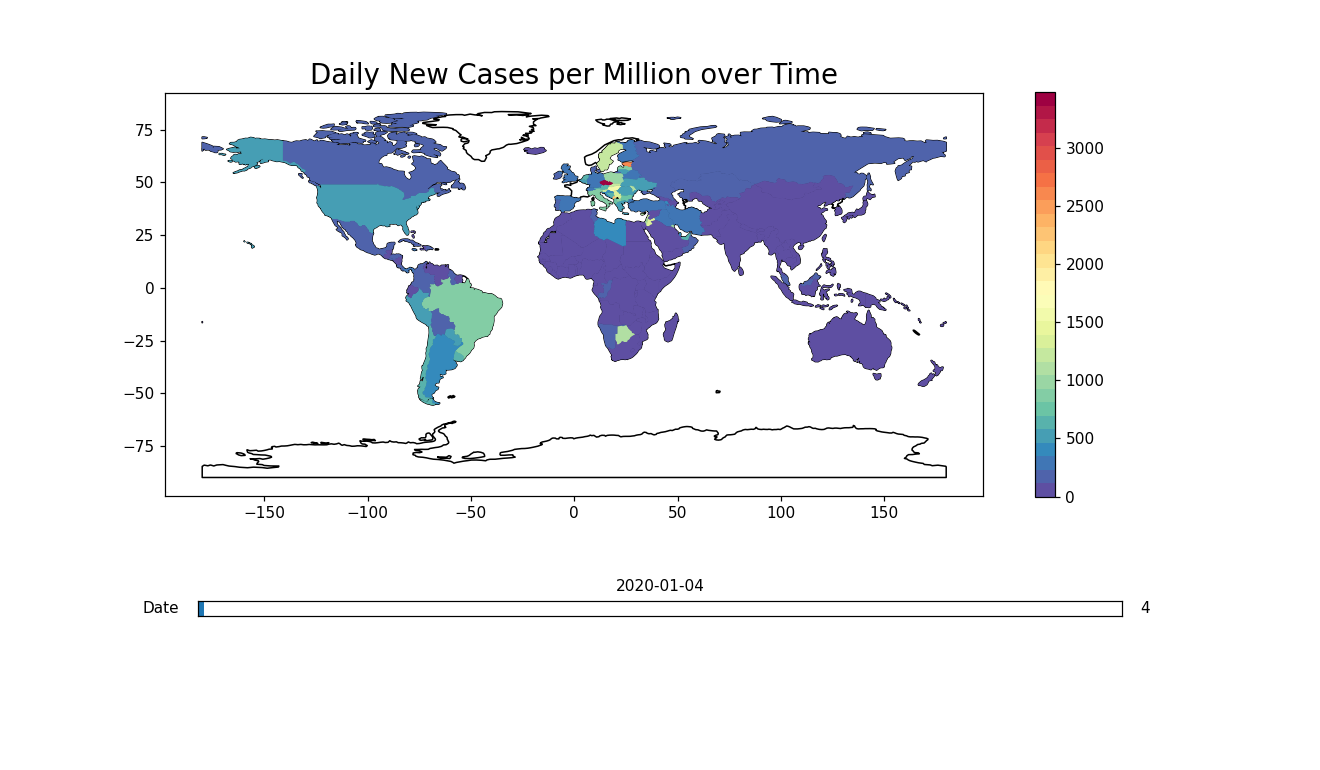

In [8]:
# Global variables
IS_MANUAL = False
ANIM_RUNNING = False
ANI = None
MANUAL_MODE = True

def main():
    global ANI

    covid = pd.read_csv('covid_with_latlong.csv')
    covid.head()

    world = geopd.read_file(geopd.datasets.get_path('naturalearth_lowres'))
    merge = pd.merge(world, covid, on='iso_a3').reset_index()
    merge['date'] = pd.to_datetime(merge['date'])

    animation = Animation(merge, 'new_cases_per_million', world)


class Chart:
    def __init__(self, world_template, day_nums, data_max):
        self.figure = None
        self.axarr = None
        self.color_map = plt.get_cmap('Spectral_r', 30)
        self.create_figure(world_template, data_max)
        self.slider = self.create_slider(day_nums)

    def create_figure(self, world_template, data_max):
        self.figure = plt.figure(figsize=(12, 7))
        self.figure.tight_layout()
        spec = gridspec.GridSpec(ncols=1, nrows=2, width_ratios=[3], height_ratios=[3, 1])
        ax0 = self.figure.add_subplot(spec[0])
        ax1 = self.figure.add_subplot(spec[1])
        world_template.plot(color='white', edgecolor='black', ax=ax0)
        ax0.set_title('Daily New Cases per Million over Time', fontsize=18)
        sm = plt.cm.ScalarMappable(cmap=self.color_map, norm=plt.Normalize(vmin=0, vmax=data_max))
        plt.colorbar(sm, orientation='vertical', ax=ax0)
        self.axarr = [ax0, ax1]

    def create_slider(self, day_nums):
        plt.sca(self.axarr[1])
        plt.axis('off')
        slider_axes = plt.axes([0.15, .2, 0.70, 0.02])
        slider = Slider(slider_axes, 'Date', valmin=1, valmax=len(day_nums), valstep=day_nums)
        return slider

class Animation:
    def __init__(self, data, target_column, world_template):
        self.data = data
        self.target_column = target_column
        self.dates = pd.unique(data['date'])
        self.dates.sort()
        self.day_nums = list(range(1, len(self.dates) + 1))
        self.chart = Chart(world_template, self.day_nums, data[target_column].max())
        self.anim = self.create_animation()
        if MANUAL_MODE:
            plt.show()


    def create_animation(self):
        global ANIM_RUNNING
        ANIM_RUNNING = True
        self.chart.slider.on_changed(self.update_slider)
        self.chart.figure.canvas.mpl_connect('button_press_event', self.on_click)
        global ANI
        anim = FuncAnimation(self.chart.figure, self.load_frame, frames=self.day_nums, interval=250, repeat=False)
        if not MANUAL_MODE:
            #fn = 'covid_spread.gif'
            #writergif = PillowWriter(fps=2)
            #anim.save(fn, writer=writergif)
            plt.show()
        return anim

    def update_slider(self, val):
        global ANI
        self.anim.event_source.stop()
        global ANIM_RUNNING
        ANIM_RUNNING = False
        global IS_MANUAL
        IS_MANUAL = True
        self.load_frame(val)

    def on_click(self, event):
        global ANIM_RUNNING
        global ANI
        (xm, ym), (xM, yM) = self.chart.slider.label.clipbox.get_points()
        if xm < event.x < xM and ym < event.y < yM:
            return
        elif ANIM_RUNNING:
            self.anim.event_source.stop()
            ANIM_RUNNING = False
        elif not ANIM_RUNNING:
            self.anim.event_source.start()
            ANIM_RUNNING = True
        global IS_MANUAL
        IS_MANUAL = False

    def get_df_by_date(self, date):
        temp_df = self.data[self.data['date']==date]
        return temp_df

    def load_frame(self, day):
        global IS_MANUAL
        date = self.dates[day-1]
        if IS_MANUAL:
            plt.title(str(date.astype('M8[D]')), fontsize=10)
            temp_df = self.get_df_by_date(date)
            temp_df.plot(column=self.target_column, cmap=self.chart.color_map, ax=self.chart.axarr[0])
            #fig.canvas.draw_idle()
        else:
            next_date = self.dates[day+1]
            plt.title(str(next_date.astype('M8[D]')), fontsize=10)
            self.chart.slider.set_val(np.where(self.dates==date)[0].item(0))
            IS_MANUAL = False
            temp_df = self.get_df_by_date(next_date)
            temp_df.plot(column=self.target_column, cmap=self.chart.color_map, ax=self.chart.axarr[0])


if __name__ == '__main__':
    main()